# PyGIMLi - Electrical Resistivity Tomography

Using the ERT solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve the corresponding inverse problem.

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/pygimli_ert/pygimli_ert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/environment.yml) file
specifies a list of packages required to run the notebooks)

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# %env MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.10.3-Linux-x86_64.sh
# %env MINICONDA_PREFIX=/usr/local
# !wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
# !chmod +x $MINICONDA_INSTALLER_SCRIPT
# !./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX
# !conda install -c gimli pygimli -y

# import sys
# _ = (sys.path.append("/usr/local/lib/python3.7/site-packages"))

# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/notebooks/pygimli_ert

We will need the following packages:

- `numpy` for matrices and matrix-related functions
- `matplotlib` for plotting
- `pygimli` for forward modelling of the problem
- `cofi` for accessing different inference solvers

Additionally, we wrap some `pygimli` code in file `pygimli_ert_lib.py` and import it
here for conciseness.

In [2]:
import numpy as np
import pygimli
from pygimli.physics import ert

from cofi import BaseProblem, InversionOptions, Inversion
from cofi.solvers import BaseSolver

from pygimli_ert_lib import *

np.random.seed(42)

## 1. Define the problem

We first define the true model, the survey and map it on a computational mesh designed for the survey and true anomaly.

Text(0.5, 1.0, 'True model')

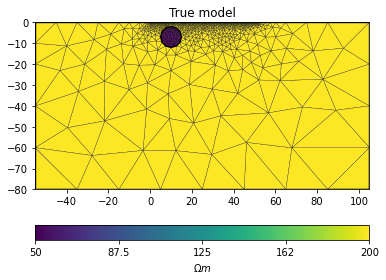

In [3]:
# PyGIMLi - define measuring scheme, geometry, forward mesh and true model
scheme = survey_scheme()
mesh, rhomap = model_true(scheme)

# plot the true model
ax = pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True)
ax[0].set_title("True model")

Generate the synthetic data as a container with all the necessary information for plotting.

In ERT problems, the model and data are by convention treated in log space. 

29/07/22 - 12:35:57 - pyGIMLi - INFO - Calculate geometric factors.


ModellingBase::setMesh() copying new mesh ... Found datafile: 51 electrodes
Found: 51 free-electrodes
rMin = 0.5, rMax = 100
NGauLeg + NGauLag for inverse Fouriertransformation: 13 + 4
Found non-Neumann domain
0.012 s
FOP updating mesh dependencies ... 0 s
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.010009229451098493 : 0.22552739004919173
Obtaining geometric factors (analytical)
Calculating response for model: min = 50 max = 200
Allocating memory for primary potential...... 0.003

No primary potential for secondary field calculation. Calculating analytically...
Factorize (Cholmod) matrix ... 0.005
Factorize (Cholmod) matrix ... 0.005
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.005
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.005
Factorize (Cholmod) matrix ... 0.004
Factoriz

Text(0.5, 1.0, 'Provided data')

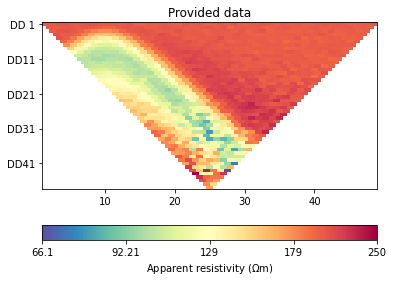

In [4]:
# PyGIMLi - generate data
data, log_data, data_cov_inv = ert_simulate(mesh, scheme, rhomap)

ax = ert.show(data)
ax[0].set_title("Provided data")

Further, we create a `pygimli.ert.ERTManager` instance to keep record of problem-specific
information like the inversion mesh, and to perform forward operation for the inversion
solvers.

In [5]:
# create PyGIMLi's ERT manager
ert_manager = ert_manager(data)

The inversion can use a different mesh and the mesh to be used should know nothing about the mesh that was designed based on the true model. We wrap two kinds of mesh as examples in the library code `pygimli_ert_lib.py`, namely triangular and rectangular mesh.

Use `imesh_tri = inversion_mesh(scheme)` to initialise a triangular mesh. This function uses PyGIMLi's own mesh generator
and generates triangular mesh automatically from given sensor locations. The resulting mesh will have a smaller area as 
unknowns to be inverted, as well as a background part with values prolongated outside from the parametric domain by PyGIMLi.
You will see an example plot in the code cell below. 

Use `imesh_rect = inversion_mesh_rect(ert_manager)` to initislise a rectangular mesh. The grid mesh is created from these x and y
nodes: `x = np.linspace(start=-5, stop=55, num=61)`, and `y = np.linspace(start=-20,stop=0,num=10)`. And again, there's a triangular
background with values prolongated outside from the parametric domain by PyGIMLi.

Here we first demonstrate how to use a *triangular mesh*. Note that this makes the inversion problem under-determined.

29/07/22 - 12:35:58 - pyGIMLi - INFO - Found 2 regions.


29/07/22 - 12:35:58 - pyGIMLi - INFO - Region with smallest marker (1) set to background


Text(0.5, 1.0, 'Mesh used for inversion')

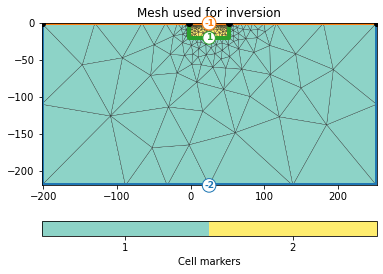

In [6]:
inv_mesh = inversion_mesh(ert_manager)
ax = pygimli.show(inv_mesh, showMesh=True, markers=True)
ax[0].set_title("Mesh used for inversion")

[This folder](https://github.com/inlab-geo/cofi-examples/tree/main/notebooks/pygimli_ert)
contains examples scripts that run inversion for triangular or rectangular meshes, with 
different inversion approaches.

With the inversion mesh created, we now define a starting model, forward operator and 
weighting matrix for regularisation using PyGIMLi.

Recall that both our model and data will be in log space when we perform inversion.

29/07/22 - 12:35:58 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.


29/07/22 - 12:35:58 - Core - WARNING - Region Nr: 1  is background and should not get a model control.


29/07/22 - 12:35:58 - pyGIMLi - INFO - Creating forward mesh from region infos.


29/07/22 - 12:35:58 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Text(0.5, 1.0, 'Starting model')

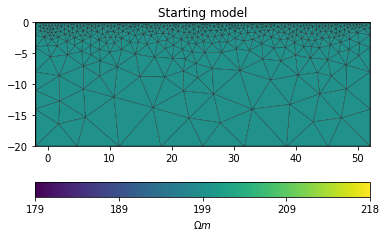

In [7]:
# PyGIMLi's forward operator (ERTModelling)
forward_oprt = ert_forward_operator(ert_manager, scheme, inv_mesh)

# extract regularisation matrix
Wm = reg_matrix(forward_oprt)

# initialise a starting model for inversion
start_model, start_model_log = starting_model(ert_manager)
ax = pygimli.show(ert_manager.paraDomain, data=start_model, label="$\Omega m$", showMesh=True)
ax[0].set_title("Starting model")

CoFI and other inference packages require a set of functions that provide the misfit, the jacobian the residual within the case of scipy standardised interfaces. All these functions are defined in the library file `pygimli_ert_lib.py`, so open this file if you'd like to find out the details. These functions are:

- `get_response`
- `get_jacobian`
- `get_residuals`
- `get_data_misfit`
- `get_regularisation`
- `get_gradient`
- `get_hessian`

With all the above forward operations set up with PyGIMLi, we now define the problem in `cofi`
by setting the problem information for a `BaseProblem` object.

In [8]:
# hyperparameters
lamda = 0.0001

# CoFI - define BaseProblem
ert_problem = BaseProblem()
ert_problem.name = "Electrical Resistivity Tomography defined through PyGIMLi"
ert_problem.set_forward(get_response, args=[forward_oprt])
ert_problem.set_jacobian(get_jacobian, args=[forward_oprt])
ert_problem.set_residual(get_residual, args=[log_data, forward_oprt])
ert_problem.set_data_misfit(get_data_misfit, args=[log_data, forward_oprt, data_cov_inv])
ert_problem.set_regularisation(get_regularisation, args=[Wm, lamda])
ert_problem.set_gradient(get_gradient, args=[log_data, forward_oprt, Wm, lamda, data_cov_inv])
ert_problem.set_hessian(get_hessian, args=[log_data, forward_oprt, Wm, lamda, data_cov_inv])
ert_problem.set_initial_model(start_model_log)

Review what information is included in the `BaseProblem` object:

In [9]:
ert_problem.summary()

Summary for inversion problem: Electrical Resistivity Tomography defined through PyGIMLi
Model shape: (831,)
----------------------------------------------------------------------------------------
List of functions/properties set by you:
['gradient', 'hessian', 'residual', 'jacobian', 'data_misfit', 'regularisation', 'forward', 'initial_model', 'model_shape']
----------------------------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['objective', 'hessian_times_vector', 'jacobian_times_vector']
----------------------------------------------------------------------------------------
List of functions/properties not set by you:
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'hessian_times_vector', 'jacobian_times_vector', 'data', 'data_covariance', 'data_covariance_inv', 'walkers_starting_pos', 'blobs_dtype', 'bounds', 'constraints']


## 2. Define the inversion options and run

### 2.1 SciPy's optimiser ([trust-exact](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-trustexact.html#optimize-minimize-trustexact))

In [10]:
ert_problem.suggest_solvers();

Based on what you've provided so far, here are possible solvers:
{
    "optimisation": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares"
    ],
    "linear least square": [],
    "sampling": []
}


In [11]:
inv_options_scipy = InversionOptions()
inv_options_scipy.set_tool("scipy.optimize.minimize")
inv_options_scipy.set_params(method="trust-exact")

Review what's been defined for the inversion we are about to run:

In [12]:
inv_options_scipy.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.optimize.minimize` - SciPy's optimisers that minimises a scalar function with respect to one or more variables, check SciPy's documentation page for a list of methods
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: 
method = trust-exact
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [13]:
inv = Inversion(ert_problem, inv_options_scipy)
inv_result = inv.run()
inv_result.summary()

/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.10/site-packages/scipy/optimize/_minimize.py:554: RuntimeWarning: Method trust-exact does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '


Summary for inversion result
FAILURE
----------------------------
status: 2
fun: 4.960150904917166
jac: [-5.29993455e-06  3.78311983e-06 -8.55017954e-06 -9.36770796e-07
 -1.97214233e-07 -6.83878714e-06 -4.07168830e-05 -8.86968037e-07
 -2.88819815e-06  2.07325860e-05  1.19913876e-05 -2.80269760e-06
 -9.46609366e-07 -4.41873329e-06 -1.77344774e-07 -1.21029607e-05
 -1.46435997e-06  5.25273340e-06  8.72664444e-06 -1.99972681e-06
 -2.38893902e-05  4.40870445e-06  2.37746948e-06  1.86790809e-05
 -2.80189184e-05  4.64597526e-06 -8.82350478e-06 -1.04833231e-05
 -4.90649097e-06 -1.37440935e-05 -8.04953242e-07  7.45788697e-06
  1.92903046e-05  9.25233566e-06 -8.21699610e-06  2.96313478e-06
 -2.70745509e-06  3.29378162e-06 -3.97520723e-06  4.37485280e-06
 -2.20484295e-06  4.47248678e-06  9.24056434e-06 -3.07947798e-06
  2.07760074e-06  7.08848994e-07  5.50294104e-06 -6.27739935e-06
  1.79698415e-06 -7.92339589e-06 -4.68714881e-06  7.75085654e-06
  1.56266206e-05  2.67002775e-06 -3.50530912e-06  5

In [14]:
inv_result.success

False

Plot the results:

Summary for inversion result
FAILURE
----------------------------
status: 2
fun: 4.960150904917166
jac: [-5.29993455e-06  3.78311983e-06 -8.55017954e-06 -9.36770796e-07
 -1.97214233e-07 -6.83878714e-06 -4.07168830e-05 -8.86968037e-07
 -2.88819815e-06  2.07325860e-05  1.19913876e-05 -2.80269760e-06
 -9.46609366e-07 -4.41873329e-06 -1.77344774e-07 -1.21029607e-05
 -1.46435997e-06  5.25273340e-06  8.72664444e-06 -1.99972681e-06
 -2.38893902e-05  4.40870445e-06  2.37746948e-06  1.86790809e-05
 -2.80189184e-05  4.64597526e-06 -8.82350478e-06 -1.04833231e-05
 -4.90649097e-06 -1.37440935e-05 -8.04953242e-07  7.45788697e-06
  1.92903046e-05  9.25233566e-06 -8.21699610e-06  2.96313478e-06
 -2.70745509e-06  3.29378162e-06 -3.97520723e-06  4.37485280e-06
 -2.20484295e-06  4.47248678e-06  9.24056434e-06 -3.07947798e-06
  2.07760074e-06  7.08848994e-07  5.50294104e-06 -6.27739935e-06
  1.79698415e-06 -7.92339589e-06 -4.68714881e-06  7.75085654e-06
  1.56266206e-05  2.67002775e-06 -3.50530912e-06  5

Text(0.5, 1.0, 'Inferred model')

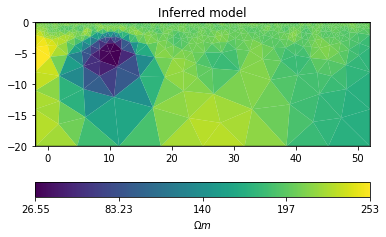

In [15]:
# convert back to normal space from log space
model = np.exp(inv_result.model)

# plot inferred model
inv_result.summary()
ax = pygimli.show(ert_manager.paraDomain, data=model, label=r"$\Omega m$")
ax[0].set_title("Inferred model")

Text(0.5, 1.0, 'Synthetic data from inferred model')

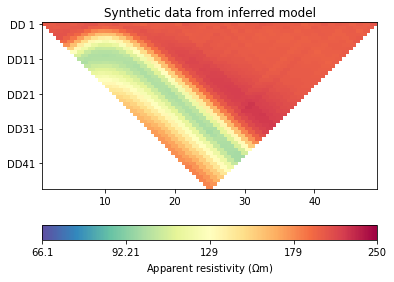

In [16]:
# plot synthetic data
d = forward_oprt.response(model)
ax = ert.showERTData(scheme, vals=d, cMin=np.min(data["rhoa"]), cMax=np.max(data["rhoa"]))
ax[0].set_title("Synthetic data from inferred model")

### 2.2 A custom [Newton's optimisation](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) approach

Now we switch to a Newton's iterative approach written by ourselves, so you'll 
have a closer look at what's happening in the loop.

First of all, define our own solver.

In [17]:
class GaussNewton(BaseSolver):
    def __init__(self, inv_problem, inv_options):
        __params = inv_options.get_params()
        self._niter = __params.get("niter", 100)
        self._verbose = __params.get("verbose", True)
        self._step = __params.get("step", 1)
        self._model_0 = inv_problem.initial_model
        self._residual = inv_problem.residual
        self._jacobian = inv_problem.jacobian
        self._gradient = inv_problem.gradient
        self._hessian = inv_problem.hessian
        self._misfit = inv_problem.data_misfit if inv_problem.data_misfit_defined else None
        self._reg = inv_problem.regularisation if inv_problem.regularisation_defined else None
        self._obj = inv_problem.objective if inv_problem.objective_defined else None

    def __call__(self):
        current_model = np.array(self._model_0)
        for i in range(self._niter):
            if self._verbose:
                print("-" * 80)
                print(f"Iteration {i+1}")
                print("model min and max:", np.min(current_model), np.max(current_model))
                if self._misfit: print("data misfit:", self._misfit(current_model))
                if self._reg: print("regularisation:", self._reg(current_model))
            term1 = self._hessian(current_model)
            term2 = - self._gradient(current_model)
            model_update = np.linalg.solve(term1, term2) * self._step
            current_model = current_model + model_update
        return {"model": current_model, "success": True}

Now, make use of this custom solver and run inversion again:

In [18]:
# hyperparameters
lamda = 0.0001
niter = 150
inv_verbose = True
step = 0.005

# CoFI - define InversionOptions
inv_options = InversionOptions()
inv_options.set_tool(GaussNewton)
inv_options.set_params(niter=niter, verbose=inv_verbose, step=step)

# CoFI - define Inversion, run it
inv = Inversion(ert_problem, inv_options)
inv_result = inv.run()

--------------------------------------------------------------------------------
Iteration 1
model min and max: 5.291310843489913 5.291310843489913
data misfit: 229.71418345445022
regularisation: 0.0


--------------------------------------------------------------------------------
Iteration 2
model min and max: 5.275884701683029 5.304449604934593


data misfit: 227.23411332788962
regularisation: 0.010102187048030783


--------------------------------------------------------------------------------
Iteration 3
model min and max: 5.262031885900452 5.310706445060276
data misfit: 224.88018892913274
regularisation: 0.02382881272664419


--------------------------------------------------------------------------------
Iteration 4
model min and max: 5.248398551565937 5.315148641783774
data misfit: 222.5841638420562
regularisation: 0.038330740534948296


--------------------------------------------------------------------------------
Iteration 5
model min and max: 5.235210460904486 5.318970381279034
data misfit: 220.32501943579953
regularisation: 0.05346144871852576


--------------------------------------------------------------------------------
Iteration 6
model min and max: 5.221988655748675 5.322505463474806
data misfit: 218.09539040624733
regularisation: 0.06913735737859916


--------------------------------------------------------------------------------
Iteration 7
model min and max: 5.2087352952573704 5.32586064835247
data misfit: 215.892125425656
regularisation: 0.0852929276262369


--------------------------------------------------------------------------------
Iteration 8
model min and max: 5.195697353190766 5.329074034021576


data misfit: 213.71361019906533
regularisation: 0.10188094041709929


--------------------------------------------------------------------------------
Iteration 9
model min and max: 5.182852523974132 5.332161355799891
data misfit: 211.5588753156785
regularisation: 0.11886698952375785


--------------------------------------------------------------------------------
Iteration 10
model min and max: 5.170183680332011 5.335368509286806
data misfit: 209.4272561757092
regularisation: 0.13622406025919231


--------------------------------------------------------------------------------
Iteration 11
model min and max: 5.15767750612393 5.3386873547565985


data misfit: 207.3182453718031
regularisation: 0.15392888174438782


--------------------------------------------------------------------------------
Iteration 12
model min and max: 5.14532342115334 5.341863067682611
data misfit: 205.23142386946935
regularisation: 0.17195977704257362


--------------------------------------------------------------------------------
Iteration 13
model min and max: 5.133112822085357 5.344904921850807
data misfit: 203.1664249261597
regularisation: 0.1902955621592294


--------------------------------------------------------------------------------
Iteration 14
model min and max: 5.121038565645579 5.347822179942048
data misfit: 201.12291605687238
regularisation: 0.20891505260332507


--------------------------------------------------------------------------------
Iteration 15
model min and max: 5.10909461257341 5.350623899375607
data misfit: 199.1005873204019
regularisation: 0.22779693654241626


--------------------------------------------------------------------------------
Iteration 16
model min and max: 5.09727577622382 5.353318771426495


data misfit: 197.09914546356381
regularisation: 0.24691982779313965


--------------------------------------------------------------------------------
Iteration 17
model min and max: 5.085577543217945 5.3559150374985585


data misfit: 195.1183106780502
regularisation: 0.26626240143027574


--------------------------------------------------------------------------------
Iteration 18
model min and max: 5.073995942551887 5.358420418114688
data misfit: 193.15781346330175
regularisation: 0.28580356014462216


--------------------------------------------------------------------------------
Iteration 19
model min and max: 5.062527443232701 5.3608420989175425
data misfit: 191.21739387575644
regularisation: 0.3055225971853175


--------------------------------------------------------------------------------
Iteration 20
model min and max: 5.051168876563503 5.3631867102996935
data misfit: 189.29679965235673
regularisation: 0.32539933587882697


--------------------------------------------------------------------------------
Iteration 21
model min and max: 5.039917379336038 5.365460364163625
data misfit: 187.3957862579242
regularisation: 0.3454142459681064


--------------------------------------------------------------------------------
Iteration 22
model min and max: 5.028770340584732 5.367668656122665
data misfit: 185.514115785678
regularisation: 0.3655485357407109


--------------------------------------------------------------------------------
Iteration 23
model min and max: 5.017725368281536 5.369816711222431
data misfit: 183.65155678774858
regularisation: 0.3857842100857199


--------------------------------------------------------------------------------
Iteration 24
model min and max: 5.006780251444858 5.371909207552506
data misfit: 181.80788344019362
regularisation: 0.40610413022550906


--------------------------------------------------------------------------------
Iteration 25
model min and max: 4.9959329412941145 5.373950416864613
data misfit: 179.9828755687684
regularisation: 0.42649202178322154


--------------------------------------------------------------------------------
Iteration 26
model min and max: 4.985181525464179 5.375944233952185
data misfit: 178.17631801144034
regularisation: 0.4469324995233555


--------------------------------------------------------------------------------
Iteration 27
model min and max: 4.97452421126887 5.377894212819134
data misfit: 176.3880007794431
regularisation: 0.4674110546510599


--------------------------------------------------------------------------------
Iteration 28
model min and max: 4.96395931253608 5.379803593413013


data misfit: 174.61771808953412
regularisation: 0.4879140482214118


--------------------------------------------------------------------------------
Iteration 29
model min and max: 4.9534852360878325 5.3816753297455895
data misfit: 172.8652685564188
regularisation: 0.5084287005330385


--------------------------------------------------------------------------------
Iteration 30
model min and max: 4.943100471064339 5.383512120042753
data misfit: 171.13045503046692
regularisation: 0.5289430509055012


--------------------------------------------------------------------------------
Iteration 31
model min and max: 4.932803581903708 5.385316428691344


data misfit: 169.41308383642144
regularisation: 0.5494459457260081


--------------------------------------------------------------------------------
Iteration 32
model min and max: 4.922593199750836 5.387090509279028


data misfit: 167.71296524705306
regularisation: 0.5699269969760974


--------------------------------------------------------------------------------
Iteration 33
model min and max: 4.912468014404341 5.388836423105429


data misfit: 166.02991298112045
regularisation: 0.5903765548599086


--------------------------------------------------------------------------------
Iteration 34
model min and max: 4.902426771556013 5.390556051429575


data misfit: 164.36374380365098
regularisation: 0.6107856710417321


--------------------------------------------------------------------------------
Iteration 35
model min and max: 4.892468266762648 5.392251128493973
data misfit: 162.71427750170972
regularisation: 0.6311460715484781


--------------------------------------------------------------------------------
Iteration 36
model min and max: 4.882591341300702 5.393923238143929
data misfit: 161.0813373059921
regularisation: 0.6514501102000925


--------------------------------------------------------------------------------
Iteration 37
model min and max: 4.8727948778025345 5.395573836384786
data misfit: 159.46474886077266
regularisation: 0.6716907506292707


--------------------------------------------------------------------------------
Iteration 38
model min and max: 4.863077799232163 5.397204260303149
data misfit: 157.86434051758454
regularisation: 0.691861522898421


--------------------------------------------------------------------------------
Iteration 39
model min and max: 4.853439062981305 5.398815737635631
data misfit: 156.27994362813175
regularisation: 0.7119564895259152


--------------------------------------------------------------------------------
Iteration 40
model min and max: 4.843877660540077 5.400409404940203


data misfit: 154.7113914392031
regularisation: 0.7319702319951853


--------------------------------------------------------------------------------
Iteration 41
model min and max: 4.8343926145955285 5.401986306121857
data misfit: 153.1585200053411
regularisation: 0.7518977962232386


--------------------------------------------------------------------------------
Iteration 42
model min and max: 4.824982976985467 5.403547402016551
data misfit: 151.62116734960452
regularisation: 0.7717346840166824


--------------------------------------------------------------------------------
Iteration 43
model min and max: 4.815647827351679 5.405093589752693
data misfit: 150.09917404040849
regularisation: 0.7914768181137846


--------------------------------------------------------------------------------
Iteration 44
model min and max: 4.806386269092812 5.406625684920524


data misfit: 148.59238263640933
regularisation: 0.8111205127410249


--------------------------------------------------------------------------------
Iteration 45
model min and max: 4.797197431706844 5.408144449231107
data misfit: 147.10063776580796
regularisation: 0.8306624530384248


--------------------------------------------------------------------------------
Iteration 46
model min and max: 4.788080466379268 5.409650589184603


data misfit: 145.6237860243799
regularisation: 0.8500996723662566


--------------------------------------------------------------------------------
Iteration 47
model min and max: 4.779034546606475 5.411144754326438
data misfit: 144.1616760628408
regularisation: 0.8694295263520225


--------------------------------------------------------------------------------
Iteration 48
model min and max: 4.770058865170829 5.412627552212823
data misfit: 142.71415837624176
regularisation: 0.8886496780313055


--------------------------------------------------------------------------------
Iteration 49
model min and max: 4.761152634921974 5.4140995474068125


data misfit: 141.28108507204146
regularisation: 0.907758069949312


--------------------------------------------------------------------------------
Iteration 50
model min and max: 4.752315086329404 5.415561259853609


data misfit: 139.86231043937474
regularisation: 0.9267529054782015


--------------------------------------------------------------------------------
Iteration 51
model min and max: 4.743545468725377 5.4170131748279395
data misfit: 138.4576902451595
regularisation: 0.9456326378931501


--------------------------------------------------------------------------------
Iteration 52
model min and max: 4.734843045651968 5.418455745995332
data misfit: 137.0670820466871
regularisation: 0.9643959505528457


--------------------------------------------------------------------------------
Iteration 53
model min and max: 4.726207099023026 5.419889398402009
data misfit: 135.69034512639965
regularisation: 0.9830417403567233


--------------------------------------------------------------------------------
Iteration 54
model min and max: 4.717636923780943 5.421314518649253
data misfit: 134.32734005793296
regularisation: 1.001569096618164


--------------------------------------------------------------------------------
Iteration 55
model min and max: 4.709131830086344 5.422731475877634
data misfit: 132.9779295692208
regularisation: 1.019977289383472


--------------------------------------------------------------------------------
Iteration 56
model min and max: 4.700691142432943 5.424140613268588


data misfit: 131.64197733763396
regularisation: 1.038265773839115


--------------------------------------------------------------------------------
Iteration 57
model min and max: 4.692314197253026 5.4255422505927235


data misfit: 130.3193490218099
regularisation: 1.0564341506471866


--------------------------------------------------------------------------------
Iteration 58
model min and max: 4.684000345176972 5.4269366873360925


data misfit: 129.0099116150112
regularisation: 1.0744821685376564


--------------------------------------------------------------------------------
Iteration 59
model min and max: 4.675748947098476 5.428324198051192
data misfit: 127.71353343911387
regularisation: 1.0924097120764877


--------------------------------------------------------------------------------
Iteration 60
model min and max: 4.66755937707599 5.4297050507178914
data misfit: 126.43008461789586
regularisation: 1.1102167898711828


--------------------------------------------------------------------------------
Iteration 61
model min and max: 4.659431019631933 5.4310794851971504
data misfit: 125.15943610782304
regularisation: 1.1279035252462501


--------------------------------------------------------------------------------
Iteration 62
model min and max: 4.65136327048717 5.432447733344818


data misfit: 123.9014608855537
regularisation: 1.1454701438204273


--------------------------------------------------------------------------------
Iteration 63
model min and max: 4.643355536126753 5.433810014742137
data misfit: 122.6560328783673
regularisation: 1.1629169744628995


--------------------------------------------------------------------------------
Iteration 64
model min and max: 4.6354072317307615 5.4351665253044015
data misfit: 121.42302740113477
regularisation: 1.1802444273245456


--------------------------------------------------------------------------------
Iteration 65
model min and max: 4.627517783787212 5.436517458870336


data misfit: 120.20232132669616
regularisation: 1.1974529992949048


--------------------------------------------------------------------------------
Iteration 66
model min and max: 4.619686626871801 5.437862988274907
data misfit: 118.99379251676498
regularisation: 1.2145432558803773


--------------------------------------------------------------------------------
Iteration 67
model min and max: 4.611913205864258 5.439203285897791
data misfit: 117.79732043902516
regularisation: 1.231515834869944


--------------------------------------------------------------------------------
Iteration 68
model min and max: 4.604196972835481 5.440538507745705


data misfit: 116.61278550186493
regularisation: 1.2483714297340665


--------------------------------------------------------------------------------
Iteration 69
model min and max: 4.596537389260179 5.441868798773033
data misfit: 115.4400695986893
regularisation: 1.2651107953668812


--------------------------------------------------------------------------------
Iteration 70
model min and max: 4.588933924906075 5.443194305163792
data misfit: 114.27905560311517
regularisation: 1.2817347331344997


--------------------------------------------------------------------------------
Iteration 71
model min and max: 4.581386057254382 5.444515152952551


data misfit: 113.12962777685908
regularisation: 1.2982440852765225


--------------------------------------------------------------------------------
Iteration 72
model min and max: 4.573893271415995 5.445831462117952


data misfit: 111.99167167496597
regularisation: 1.3146397419449682


--------------------------------------------------------------------------------
Iteration 73
model min and max: 4.566455060606381 5.447143355534274
data misfit: 110.86507371041692
regularisation: 1.330922623761924


--------------------------------------------------------------------------------
Iteration 74
model min and max: 4.559070924813987 5.448450941267092
data misfit: 109.74972168905651
regularisation: 1.347093685531491


--------------------------------------------------------------------------------
Iteration 75
model min and max: 4.551740370186466 5.449754315225619
data misfit: 108.64550462298934
regularisation: 1.3631539059684252


--------------------------------------------------------------------------------
Iteration 76
model min and max: 4.544462910908468 5.451053583545712
data misfit: 107.552312402364
regularisation: 1.3791042909409945


--------------------------------------------------------------------------------
Iteration 77
model min and max: 4.537238068038501 5.45234883371994
data misfit: 106.47003619955336
regularisation: 1.394945865308424


--------------------------------------------------------------------------------
Iteration 78
model min and max: 4.530065368466265 5.453640151819141


data misfit: 105.39856824158795
regularisation: 1.410679675908295


--------------------------------------------------------------------------------
Iteration 79
model min and max: 4.522944345423896 5.454927619243493


data misfit: 104.33780180995228
regularisation: 1.4263067781250764


--------------------------------------------------------------------------------
Iteration 80
model min and max: 4.515874537837962 5.456211310978717


data misfit: 103.28763128559409
regularisation: 1.4418282401242357


--------------------------------------------------------------------------------
Iteration 81
model min and max: 4.508855493270026 5.457491300843154
data misfit: 102.24795227460832
regularisation: 1.4572451454799322


--------------------------------------------------------------------------------
Iteration 82
model min and max: 4.501886761879233 5.458767657969999
data misfit: 101.21866112882363
regularisation: 1.4725585816524147


--------------------------------------------------------------------------------
Iteration 83
model min and max: 4.494967901318088 5.460040446672147


data misfit: 100.19965538774181
regularisation: 1.4877696413196189


--------------------------------------------------------------------------------
Iteration 84
model min and max: 4.488098473702789 5.461309723120059
data misfit: 99.19083378846311
regularisation: 1.5028794188214711


--------------------------------------------------------------------------------
Iteration 85
model min and max: 4.481278048430499 5.462575547451479
data misfit: 98.19209570727084
regularisation: 1.5178890100823696


--------------------------------------------------------------------------------
Iteration 86
model min and max: 4.47450619898605 5.463837975817314
data misfit: 97.20334176265881
regularisation: 1.5327995203311395


--------------------------------------------------------------------------------
Iteration 87
model min and max: 4.467782504131303 5.465097054742566


data misfit: 96.22447356239108
regularisation: 1.5476120399127393


--------------------------------------------------------------------------------
Iteration 88
model min and max: 4.461106547429248 5.4663528321699415
data misfit: 95.25539353083107
regularisation: 1.562327660713067


--------------------------------------------------------------------------------
Iteration 89
model min and max: 4.4544779178524125 5.467605355818469
data misfit: 94.29600528769339
regularisation: 1.576947477074217


--------------------------------------------------------------------------------
Iteration 90
model min and max: 4.447896209598003 5.468854667022207
data misfit: 93.34621325777489
regularisation: 1.5914725697576797


--------------------------------------------------------------------------------
Iteration 91
model min and max: 4.441361021254668 5.470100804739342
data misfit: 92.40592294458668
regularisation: 1.6059040139449874


--------------------------------------------------------------------------------
Iteration 92
model min and max: 4.434871956845149 5.471343807991884
data misfit: 91.47504046287139
regularisation: 1.620242883493329


--------------------------------------------------------------------------------
Iteration 93
model min and max: 4.428428622778542 5.47258370897984


data misfit: 90.55347314896551
regularisation: 1.6344902333741027


--------------------------------------------------------------------------------
Iteration 94
model min and max: 4.422030632871253 5.473820544585454
data misfit: 89.64112924285119
regularisation: 1.6486471176184465


--------------------------------------------------------------------------------
Iteration 95
model min and max: 4.415677603772573 5.47505434565618
data misfit: 88.73791789694776
regularisation: 1.6627145835974841


--------------------------------------------------------------------------------
Iteration 96
model min and max: 4.409369156141724 5.476285137004788


data misfit: 87.8437488099508
regularisation: 1.6766936566080999


--------------------------------------------------------------------------------
Iteration 97
model min and max: 4.403104916155781 5.477512950286583
data misfit: 86.95853313942787
regularisation: 1.6905853585724169


--------------------------------------------------------------------------------
Iteration 98
model min and max: 4.3968845135491605 5.478737814003295


data misfit: 86.08218249025609
regularisation: 1.704390702282606


--------------------------------------------------------------------------------
Iteration 99
model min and max: 4.390707580980788 5.479959743124051
data misfit: 85.21460937810053
regularisation: 1.7181106804312105


--------------------------------------------------------------------------------
Iteration 100
model min and max: 4.384573757293067 5.481178772929908
data misfit: 84.35572743571626
regularisation: 1.7317462762883788


--------------------------------------------------------------------------------
Iteration 101
model min and max: 4.37848268385019 5.482394915549808
data misfit: 83.50545076867697
regularisation: 1.7452984675916638


--------------------------------------------------------------------------------
Iteration 102
model min and max: 4.372434005712248 5.483608192047057
data misfit: 82.66369488589048
regularisation: 1.7587682050430515


--------------------------------------------------------------------------------
Iteration 103
model min and max: 4.366427372981385 5.484818622806528
data misfit: 81.83037531711092
regularisation: 1.7721564411301496


--------------------------------------------------------------------------------
Iteration 104
model min and max: 4.360462438842501 5.486026226687485
data misfit: 81.00540905874284
regularisation: 1.7854641025344429


--------------------------------------------------------------------------------
Iteration 105
model min and max: 4.354538859621143 5.487231017746706
data misfit: 80.18871373270579
regularisation: 1.7986921078785603


--------------------------------------------------------------------------------
Iteration 106
model min and max: 4.348656295548815 5.488433010953574
data misfit: 79.3802078191352
regularisation: 1.8118413588959423


--------------------------------------------------------------------------------
Iteration 107
model min and max: 4.342814410669894 5.489632220252362


data misfit: 78.5798104960511
regularisation: 1.8249127494924247


--------------------------------------------------------------------------------
Iteration 108
model min and max: 4.337012873230149 5.49082866182503
data misfit: 77.78744159022021
regularisation: 1.8379071543383352


--------------------------------------------------------------------------------
Iteration 109
model min and max: 4.331251353226986 5.49202234222385
data misfit: 77.0030221191503
regularisation: 1.8508254342962562


--------------------------------------------------------------------------------
Iteration 110
model min and max: 4.325529525684867 5.493213276524976


data misfit: 76.2264735868664
regularisation: 1.8636684387271603


--------------------------------------------------------------------------------
Iteration 111
model min and max: 4.319847067333464 5.494401469773859


data misfit: 75.45771830630939
regularisation: 1.8764369944259467


--------------------------------------------------------------------------------
Iteration 112
model min and max: 4.314203660311148 5.495586942369986


data misfit: 74.69667928818569
regularisation: 1.8891319271500493


--------------------------------------------------------------------------------
Iteration 113
model min and max: 4.308598988197318 5.496769691862814


data misfit: 73.9432804205545
regularisation: 1.9017540358295146


--------------------------------------------------------------------------------
Iteration 114
model min and max: 4.303032737924173 5.497949733301076
data misfit: 73.19744644654939
regularisation: 1.9143041161600465


--------------------------------------------------------------------------------
Iteration 115
model min and max: 4.297504599553805 5.499127067407529


data misfit: 72.45910234955997
regularisation: 1.9267829424340024


--------------------------------------------------------------------------------
Iteration 116
model min and max: 4.292014268015556 5.500301706226273
data misfit: 71.72817455598855
regularisation: 1.9391912776869846


--------------------------------------------------------------------------------
Iteration 117
model min and max: 4.2865614387818365 5.501473654640174


data misfit: 71.00458935794444
regularisation: 1.9515298763040128


--------------------------------------------------------------------------------
Iteration 118
model min and max: 4.2811458118912675 5.502642916649102
data misfit: 70.28827462611076
regularisation: 1.9637994606400027


--------------------------------------------------------------------------------
Iteration 119
model min and max: 4.275767090356068 5.5038094971270395
data misfit: 69.57915840577007
regularisation: 1.9760007659602297


--------------------------------------------------------------------------------
Iteration 120
model min and max: 4.270424978966438 5.504973399532894


data misfit: 68.87716960268716
regularisation: 1.9881344921525441


--------------------------------------------------------------------------------
Iteration 121
model min and max: 4.265119186557899 5.5061346315299176


data misfit: 68.18223767683703
regularisation: 2.0002013392621696


--------------------------------------------------------------------------------
Iteration 122
model min and max: 4.25984942391775 5.507293193605666


data misfit: 67.49429299120072
regularisation: 2.012201988899612


--------------------------------------------------------------------------------
Iteration 123
model min and max: 4.254615404352753 5.508449087678306


data misfit: 66.81326653857496
regularisation: 2.0241371062262887


--------------------------------------------------------------------------------
Iteration 124
model min and max: 4.249416845883812 5.509602317769961


data misfit: 66.13908980773923
regularisation: 2.036007357376696


--------------------------------------------------------------------------------
Iteration 125
model min and max: 4.24425346700836 5.510752883796357
data misfit: 65.47169512494415
regularisation: 2.0478133761708777


--------------------------------------------------------------------------------
Iteration 126
model min and max: 4.239124990321992 5.511900792591791
data misfit: 64.81101541904546
regularisation: 2.0595558009125123


--------------------------------------------------------------------------------
Iteration 127
model min and max: 4.234031140028985 5.513046038501569


data misfit: 64.15698425894404
regularisation: 2.0712352437197783


--------------------------------------------------------------------------------
Iteration 128
model min and max: 4.228971644786882 5.514188629034015


data misfit: 63.50953587446696
regularisation: 2.0828523203449425


--------------------------------------------------------------------------------
Iteration 129
model min and max: 4.223946233380481 5.515328559919014


data misfit: 62.86860523167743
regularisation: 2.094407619626665


--------------------------------------------------------------------------------
Iteration 130
model min and max: 4.2189546388568315 5.5164658327312885


data misfit: 62.234127755812324
regularisation: 2.105901732755306


--------------------------------------------------------------------------------
Iteration 131
model min and max: 4.213996595744589 5.517600445803457
data misfit: 61.60603968767131
regularisation: 2.117335225002032


--------------------------------------------------------------------------------
Iteration 132
model min and max: 4.209071841074928 5.518732401351488


data misfit: 60.98427768830887
regularisation: 2.128708658150897


--------------------------------------------------------------------------------
Iteration 133
model min and max: 4.204180115191007 5.519861698911811


data misfit: 60.36877905447835
regularisation: 2.1400225904779018


--------------------------------------------------------------------------------
Iteration 134
model min and max: 4.199321161012221 5.520988338707709


data misfit: 59.75948186612955
regularisation: 2.1512775557408585


--------------------------------------------------------------------------------
Iteration 135
model min and max: 4.194494723011568 5.52211232002908


data misfit: 59.15632473765331
regularisation: 2.162474084285131


--------------------------------------------------------------------------------
Iteration 136
model min and max: 4.189700547813593 5.523233635581318


data misfit: 58.55924679785758
regularisation: 2.17361269450887


--------------------------------------------------------------------------------
Iteration 137
model min and max: 4.184938385353648 5.524352289290216
data misfit: 57.96818782833373
regularisation: 2.1846938946225185


--------------------------------------------------------------------------------
Iteration 138
model min and max: 4.180207986349643 5.5254682789722755
data misfit: 57.38308828504618
regularisation: 2.1957181812694944


--------------------------------------------------------------------------------
Iteration 139
model min and max: 4.175509105046117 5.526581601577841


data misfit: 56.80388905611533
regularisation: 2.206686048255163


--------------------------------------------------------------------------------
Iteration 140
model min and max: 4.170841498335347 5.52769225921945
data misfit: 56.23053156803228
regularisation: 2.2175979719211316


--------------------------------------------------------------------------------
Iteration 141
model min and max: 4.166204924200246 5.528800244757877


data misfit: 55.6629579112169
regularisation: 2.2284544252694247


--------------------------------------------------------------------------------
Iteration 142
model min and max: 4.1615991434363835 5.529905557972745


data misfit: 55.101110884688204
regularisation: 2.2392558660700708


--------------------------------------------------------------------------------
Iteration 143
model min and max: 4.157023918140072 5.531008193305929
data misfit: 54.544933614354704
regularisation: 2.250002745311269


--------------------------------------------------------------------------------
Iteration 144
model min and max: 4.152479013758978 5.532108156181796


data misfit: 53.99436982441884
regularisation: 2.2606955064276786


--------------------------------------------------------------------------------
Iteration 145
model min and max: 4.147964197682626 5.533205438013997


data misfit: 53.44936386452144
regularisation: 2.271334588970167


--------------------------------------------------------------------------------
Iteration 146
model min and max: 4.143479238675066 5.534300038404503
data misfit: 52.90986067373963
regularisation: 2.2819204136179465


--------------------------------------------------------------------------------
Iteration 147
model min and max: 4.139023907326331 5.5353919550061885


data misfit: 52.37580550427695
regularisation: 2.2924533988415514


--------------------------------------------------------------------------------
Iteration 148
model min and max: 4.134597977747315 5.536481183696906


data misfit: 51.84714429588892
regularisation: 2.3029339591668254


--------------------------------------------------------------------------------
Iteration 149
model min and max: 4.130201224735703 5.5375677231979745


data misfit: 51.323823633671815
regularisation: 2.3133624918468945


--------------------------------------------------------------------------------
Iteration 150
model min and max: 4.12583342616409 5.538651572065275


data misfit: 50.805790300154634
regularisation: 2.323739399595268


Text(0.5, 1.0, 'Inferred model')

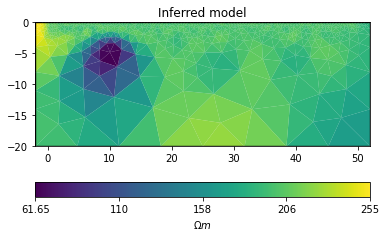

In [19]:
# convert from log space
model = np.exp(inv_result.model)

# plot inferred model
ax = pygimli.show(ert_manager.paraDomain, data=model, label=r"$\Omega m$")
ax[0].set_title("Inferred model")

Text(0.5, 1.0, 'Synthetic data from inferred model')

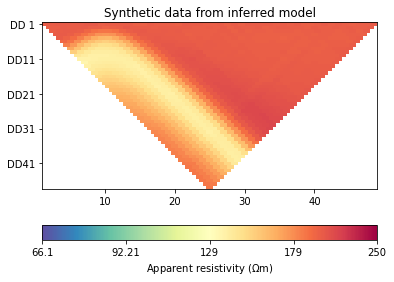

In [20]:
# plot synthetic data
d = forward_oprt.response(model)
ax = ert.showERTData(scheme, vals=d, cMin=np.min(data["rhoa"]), cMax=np.max(data["rhoa"]))
ax[0].set_title("Synthetic data from inferred model")

## 3. What's next?

Now that we've seen the PyGIMLi ERT problem solved by two different inversion approaches through CoFI,
it would be nice to see more inversion solvers (even a sampler!) and a similar problem
defined with a rectangular mesh. If you'd like to see some self-contained examples, head to
[this GitHub folder](https://github.com/inlab-geo/cofi-examples/tree/main/notebooks/pygimli_ert)
to explore more.

<!-- ### 2.3 Bayesian sampling with emcee (exploration)

CoFI needs more assumptions about the problem for a sampler to work - these are
the log of posterior distribution density and walkers' starting positions.

For the log posterior, we define here by specifying `log_prior` and `log_likelihood`.
And CoFI will combine them to get the `log_posterior`. -->

---
## Watermark

In [21]:
watermark_list = ["cofi", "numpy", "scipy", "pygimli", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev8
numpy 1.21.6
scipy 1.8.1
pygimli 1.2.6
matplotlib 3.5.2
emcee 3.1.2
arviz 0.12.1
